In [ ]:
import sys
sys.path.append('04_MNIST_GAN')
from gan_helper import *
from gan_net import *

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root='04_MNIST_GAN/data/data', 
                          train=True,
                          download=True,
                          transform=transform)

# Create images directory if it doesn't exist
#os.makedirs("images", exist_ok=True)

mnist_train = torchvision.datasets.MNIST(root='04_MNIST_GAN/data', train=True, 
                                       download=True, transform=transform)
dataloader = DataLoader(mnist_train, batch_size=128, shuffle=True, drop_last=True)

# Parameters
latent_dim = 100
num_classes = 10
img_size = 28
channels = 1

Using device: cuda


In [2]:
# Build dataloader
dl = DataLoader(dataset=train_ds,
                shuffle=True,
                batch_size=64)

# Examine a sample batch from the dataloader
image_batch = next(iter(dl))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)

2 <class 'list'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [3]:
## ----------------------------------------------------------------------------
## Visualise a sample batch
## ----------------------------------------------------------------------------

def display_images(images, n_cols=4, figsize=(12, 6)):
    """
    Utility function to display a collection of images in a grid
    
    Parameters
    ----------
    images: Tensor
            tensor of shape (batch_size, channel, height, width)
            containing images to be displayed
    n_cols: int
            number of columns in the grid
            
    Returns
    -------
    None
    """
    plt.style.use('ggplot')
    n_images = len(images)
    n_rows = math.ceil(n_images / n_cols)
    plt.figure(figsize=figsize)
    for idx in range(n_images):
        ax = plt.subplot(n_rows, n_cols, idx+1)
        image = images[idx]
        # make dims H x W x C
        image = image.permute(1, 2, 0)
        cmap = 'gray' if image.shape[2] == 1 else plt.cm.viridis
        ax.imshow(image, cmap=cmap)
        ax.set_xticks([])
        ax.set_yticks([])        
    plt.tight_layout()
    plt.show()

def real_loss(predicted_outputs, loss_fn, device):
    """
    Function for calculating loss when samples are drawn from real dataset
    
    Parameters
    ----------
    predicted_outputs: Tensor
                       predicted logits
            
    Returns
    -------
    real_loss: int
    """
    batch_size = predicted_outputs.shape[0]
    # Targets are set to 1 here because we expect prediction to be 
    # 1 (or near 1) since samples are drawn from real dataset
    targets = torch.ones(batch_size).to(device)
    real_loss = loss_fn(predicted_outputs.squeeze(), targets)
    
    return real_loss


def fake_loss(predicted_outputs, loss_fn, device):
    """
    Function for calculating loss when samples are generated fake samples
    
    Parameters
    ----------
    predicted_outputs: Tensor
                       predicted logits
            
    Returns
    -------
    fake_loss: int
    """
    batch_size = predicted_outputs.shape[0]
    # Targets are set to 0 here because we expect prediction to be 
    # 0 (or near 0) since samples are generated fake samples
    targets = torch.zeros(batch_size).to(device)
    fake_loss = loss_fn(predicted_outputs.squeeze(), targets)
    
    return fake_loss 



def visualize_neighbors(fake_image, real_images, indices, n_neighbors=15, figsize=(15, 3)):
    """
    Visualize a generated image and its nearest neighbors from the training set
    
    Parameters:
    -----------
    fake_image : torch.Tensor or numpy.ndarray
        Generated image to compare against, shape [1, 1, 28, 28] or [1, 784]
    real_images : numpy.ndarray
        Dataset containing all training images, shape [n_samples, 1, 28, 28]
    indices : numpy.ndarray
        Indices of nearest neighbors to display
    n_neighbors : int, default=15
        Number of neighbors to display
    figsize : tuple, default=(15, 3)
        Figure size for the plot
        
    Returns:
    -------
    None
    """
    # Convert tensors to numpy if needed
    if torch.is_tensor(fake_image):
        fake_image = fake_image.cpu().numpy()
    
    # Ensure fake_image is in correct shape
    if fake_image.shape[-1] == 784:
        fake_image = fake_image.reshape(-1, 1, 28, 28)
    
    # Create subplot grid
    plt.figure(figsize=figsize)
    
    # Plot generated image
    plt.subplot(1, n_neighbors + 1, 1)
    plt.imshow(fake_image[0, 0], cmap='gray')
    plt.title('Generated')
    plt.axis('off')
    
    # Plot nearest neighbors
    for idx, neighbor_idx in enumerate(indices[:n_neighbors]):
        plt.subplot(1, n_neighbors + 1, idx + 2)
        plt.imshow(real_images[neighbor_idx, 0], cmap='gray')
        plt.title(f'#{idx+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def sample_images(n_row, batches_done):
    """Saves a grid of generated digits"""
    try:
        # Sample noise
        z = torch.randn(n_row**2, latent_dim).to(device)
        # Get labels ranging from 0 to n_classes for n rows
        labels = torch.tensor([num for _ in range(n_row) for num in range(n_row)]).to(device)
        
        generator.eval()  # Set to eval mode
        with torch.no_grad():
            gen_imgs = generator(z, labels)
        generator.train()  # Set back to train mode
        
        # Ensure the images directory exists
        os.makedirs("images", exist_ok=True)
        
        # Save the generated images
        save_image(gen_imgs.data, f"images/{batches_done}.png", nrow=n_row, normalize=True)
    except Exception as e:
        print(f"Error in sample_images: {str(e)}")

def train_minst_gan(d, g, d_optim, g_optim, loss_fn, dl, n_epochs, device, verbose=False):
    print(f'Training on [{device}]...')
    
    # Generate a batch (say 16) of latent image vector (z) of fixed size 
    # (say 100 pix) to be as input to the Generator after each epoch of 
    # training to generate a fake image. We'll visualise these fake images
    # to get a sense how generator improves as training progresses
    z_size = 100
    fixed_z = np.random.uniform(-1, 1, size=(16, z_size))
    fixed_z = torch.from_numpy(fixed_z).float().to(device)          
    fixed_samples = []
    d_losses = []
    g_losses = []
    
    
    # Move discriminator and generator to available device
    d = d.to(device)
    g = g.to(device)
    
    for epoch in range(n_epochs):
        print(f'Epoch [{epoch+1}/{n_epochs}]:')
        # Switch the training mode on
        d.train()
        g.train()
        d_running_batch_loss = 0
        g_running_batch_loss = 0
        for curr_batch, (real_images, _) in enumerate(dl):
            # Move input batch to available device
            real_images = real_images.to(device)
            
            ## ----------------------------------------------------------------
            ## Train discriminator using real and then fake MNIST images,  
            ## then compute the total-loss and back-propogate the total-loss
            ## ----------------------------------------------------------------
            
            # Reset gradients
            d_optim.zero_grad()
            
            # Real MNIST images
            # Convert real_images value range of 0 to 1 to -1 to 1
            # this is required because latter discriminator would be required 
            # to consume generator's 'tanh' output which is of range -1 to 1
            real_images = (real_images * 2) - 1  
            d_real_logits_out = d(real_images)
            d_real_loss = real_loss(d_real_logits_out, loss_fn, device)
            #d_real_loss = real_loss(d_real_logits_out, smooth=True)
            
            # Fake images
            with torch.no_grad():
                # Generate a batch of random latent vectors 
                z = np.random.uniform(-1, 1, size=(dl.batch_size, z_size))
                z = torch.from_numpy(z).float().to(device)
                # Generate batch of fake images
                fake_images = g(z) 
            # feed fake-images to discriminator and compute the 
            # fake_loss (i.e. target label = 0)
            d_fake_logits_out = d(fake_images)
            d_fake_loss = fake_loss(d_fake_logits_out, loss_fn, device)
            #d_fake_loss = fake_loss(d_fake_logits_out)
            # Compute total discriminator loss
            d_loss = d_real_loss + d_fake_loss
            # Backpropogate through discriminator
            d_loss.backward()
            d_optim.step()
            # Save discriminator batch loss
            d_running_batch_loss += d_loss
            
            ## ----------------------------------------------------------------
            ## Train generator, compute the generator loss which is a measure
            ## of how successful the generator is in tricking the discriminator 
            ## and finally back-propogate generator loss
            ## ----------------------------------------------------------------

            # Reset gradients
            g_optim.zero_grad()
            
            # Generate a batch of random latent vectors
            #z = torch.rand(size=(dl.batch_size, z_size)).to(device)
            z = np.random.uniform(-1, 1, size=(dl.batch_size, z_size))
            z = torch.from_numpy(z).float().to(device)       
            # Generate a batch of fake images, feed them to discriminator
            # and compute the generator loss as real_loss 
            # (i.e. target label = 1)
            fake_images = g(z) 
            g_logits_out = d(fake_images)
            g_loss = real_loss(g_logits_out, loss_fn, device)
            #g_loss = real_loss(g_logits_out)
            # Backpropogate thorugh generator
            g_loss.backward()
            g_optim.step()
            # Save discriminator batch loss
            g_running_batch_loss += g_loss
            
            # Display training stats for every 200 batches 
            if curr_batch % 400 == 0 and verbose:
                print(f'\tBatch [{curr_batch:>4}/{len(dl):>4}] - d_batch_loss: {d_loss.item():.6f}\tg_batch_loss: {g_loss.item():.6f}')
            
        # Compute epoch losses as total_batch_loss/number_of_batches
        d_epoch_loss = d_running_batch_loss.item()/len(dl)
        g_epoch_loss = g_running_batch_loss.item()/len(dl)
        d_losses.append(d_epoch_loss)
        g_losses.append(g_epoch_loss)
        
        # Display training stats for every 200 batches 
        print(f'epoch_d_loss: {d_epoch_loss:.6f} \tepoch_g_loss: {g_epoch_loss:.6f}')
        
        # Generate fake images from fixed latent vector using the trained 
        # generator so far and save images for latter viewing
        g.eval()
        fixed_samples.append(g(fixed_z).detach().cpu())
        
    # Finally write generated fake images from fixed latent vector to disk
    with open('04_MNIST_GAN/fixed_samples.pkl', 'wb') as f:
        pkl.dump(fixed_samples, f)
     
    return d_losses, g_losses

def knn_search(query, dataset, k=5, metric='euclidean'):
    """
    Perform KNN search for a query point in a dataset
    
    Parameters:
    -----------
    query : numpy.ndarray
        Query point of shape matching dataset samples
    dataset : numpy.ndarray
        Dataset to search in, shape [n_samples, n_features]
    k : int, default=5
        Number of neighbors to find
    metric : str, default='euclidean'
        Distance metric to use ('euclidean' or 'cosine')
        
    Returns:
    --------
    indices : numpy.ndarray
        Indices of k nearest neighbors
    distances : numpy.ndarray
        Distances to k nearest neighbors
    """
    # Ensure inputs are numpy arrays with correct shape
    query = np.asarray(query).flatten()
    dataset = np.asarray(dataset)
    if len(dataset.shape) > 2:
        dataset = dataset.reshape(dataset.shape[0], -1)
    
    # Calculate distances
    if metric == 'euclidean':
        distances = np.sqrt(((dataset - query) ** 2).sum(axis=1))
    elif metric == 'cosine':
        norm_query = query / np.linalg.norm(query)
        norm_dataset = dataset / np.linalg.norm(dataset, axis=1, keepdims=True)
        distances = 1 - (norm_dataset @ norm_query)
    else:
        raise ValueError(f"Unknown metric: {metric}")
    
    # Get top-k indices and distances
    top_indices = np.argsort(distances)[:k]
    top_distances = distances[top_indices]
    
    return top_indices, top_distances

def collect_discriminator_activations_for_generated(generator, discriminator, z, device='cuda'):
    """
    Collect discriminator activations for a single generated image
    
    Parameters:
    -----------
    generator : torch.nn.Module
        The generator model
    discriminator : torch.nn.Module
        The discriminator model
    z : torch.Tensor
        Input latent vector
    device : str, default='cuda'
        Device to run inference on
        
    Returns:
    --------
    numpy.ndarray
        Array containing concatenated activations from all layers
    """
    generator.eval()
    discriminator.eval()
    
    # Register hooks for discriminator
    hooks = []
    activation_dict = {}
    layer_activations = {}
    
    # Register hooks for all linear and LeakyReLU layers
    for name, module in discriminator.named_modules():
        if isinstance(module, (nn.Linear, nn.LeakyReLU)):
            layer_activations[name] = []
            hooks.append(module.register_forward_hook(
                lambda m, inp, out, name=name: activation_dict.update({name: out.detach().cpu()})
            ))
    
    with torch.no_grad():
        # Generate fake image
        fake_image = generator(z)
        
        # Get discriminator activations
        _ = discriminator(fake_image)
        
        # Store activations from each layer
        all_activations = []
        for name in layer_activations.keys():
            if name in activation_dict:
                # Flatten and store activation
                flattened = activation_dict[name].view(activation_dict[name].size(0), -1)
                all_activations.append(flattened)
    
    # Clean up hooks
    for hook in hooks:
        hook.remove()
    
    # Concatenate all flattened layers along feature dimension
    final_activations = torch.cat(all_activations, dim=1).numpy()
    
    print(f"Final activations shape for generated image: {final_activations.shape}")
    return final_activations

def collect_discriminator_activations(discriminator, dataloader, device='cuda'):
    """
    Collect discriminator activations and inputs
    
    Parameters:
    -----------
    discriminator : torch.nn.Module
        The discriminator model
    dataloader : DataLoader
        DataLoader containing the input data
    device : str, default='cuda'
        Device to run inference on
        
    Returns:
    --------
    numpy.ndarray
        Array containing concatenated activations from all layers
    numpy.ndarray
        Array containing the labels
    numpy.ndarray
        Array containing the input images
    """
    discriminator.eval()
    
    # Register hooks and get layer names first
    hooks = []
    activation_dict = {}
    layer_activations = {}
    all_inputs = []
    
    # Register hooks for all linear and LeakyReLU layers
    for name, module in discriminator.named_modules():
        if isinstance(module, (nn.Linear, nn.LeakyReLU)):
            layer_activations[name] = []
            hooks.append(module.register_forward_hook(
                lambda m, inp, out, name=name: activation_dict.update({name: out.detach().cpu()})
            ))
    
    print("Capturing discriminator activations...")
    print(f"Monitoring layers: {list(layer_activations.keys())}")
    total_batches = len(dataloader)
    
    all_labels = []
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(dataloader):
            # Store input images
            all_inputs.append(imgs.cpu())
            
            imgs = imgs.to(device)
            _ = discriminator(imgs)
            
            # Store activations from each layer
            for name in layer_activations.keys():
                if name in activation_dict:
                    layer_activations[name].append(activation_dict[name])
            
            all_labels.append(labels)
            
            # Print progress
            if batch_idx % (total_batches // 10) == 0:
                print(f"Progress: {batch_idx}/{total_batches} batches")
    
    # Clean up hooks
    for hook in hooks:
        hook.remove()
    
    # First concatenate all batches for each layer
    concatenated_layers = {}
    for name in layer_activations.keys():
        if layer_activations[name]:
            concatenated_layers[name] = torch.cat(layer_activations[name], dim=0)
    
    # Now flatten and concatenate all layers together
    all_activations = []
    for name, activations in concatenated_layers.items():
        flattened = activations.view(activations.size(0), -1)  # Flatten each layer
        all_activations.append(flattened)
    
    # Concatenate all flattened layers along feature dimension
    final_activations = torch.cat(all_activations, dim=1).numpy()
    
    # Concatenate labels and inputs
    labels = torch.cat(all_labels, dim=0).numpy()
    inputs = torch.cat(all_inputs, dim=0).numpy()
    
    print(f"Final concatenated activations shape: {final_activations.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Inputs shape: {inputs.shape}")
    
    return final_activations, labels, inputs

def blend_samples(dataset, indices, distances, reference=None, epsilon=1e-10):
    """
    Blend samples using inverse distance weighting and optionally compare to reference
    
    Parameters:
    -----------
    dataset : numpy.ndarray
        Dataset containing samples to blend, shape [n_samples, ...] 
        Can be either activations [60000, features] or images [60000, 1, 28, 28]
    indices : numpy.ndarray
        Indices of samples to blend
    distances : numpy.ndarray
        Distances to selected samples, matching indices
    reference : numpy.ndarray or torch.Tensor, optional
        Reference sample to compare blended result against
    epsilon : float, default=1e-10
        Small constant to avoid division by zero
        
    Returns:
    --------
    blended : numpy.ndarray
        Blended sample with same shape as a single item from dataset
    ref_distance : float or None
        L2 distance to reference sample if provided, else None
    """
    # Ensure inputs are numpy arrays
    dataset = np.asarray(dataset)
    distances = np.asarray(distances)
    
    # Calculate inverse distance weights
    weights = 1 / (distances + epsilon)
    weights = weights / np.sum(weights)
    
    # Select samples to blend
    samples = dataset[indices]
    
    # For image inputs, reshape to [n_samples, -1]
    if len(samples.shape) > 2:
        samples_flat = samples.reshape(len(samples), -1)
    else:
        samples_flat = samples
        
    weights = weights.reshape(-1, 1)  # Shape: [n_samples, 1]
    
    # Calculate weighted average
    blended_flat = np.sum(samples_flat * weights, axis=0)
    
    # Reshape back to original shape
    if len(dataset.shape) > 2:
        # For images, reshape to [1, 28, 28] or [1, 1, 28, 28]
        if len(dataset.shape) == 4:
            blended = blended_flat.reshape(1, dataset.shape[2], dataset.shape[3])
        else:
            blended = blended_flat.reshape(dataset.shape[1:])
    else:
        # For activations, keep flat
        blended = blended_flat
    
    # Calculate distance to reference if provided
    ref_distance = None
    if reference is not None:
        # Convert torch tensor to numpy if needed
        if torch.is_tensor(reference):
            reference = reference.cpu().numpy()
        reference = np.asarray(reference).flatten()
        ref_distance = np.sqrt(np.sum((blended_flat - reference.flatten()) ** 2))
    
    return blended, ref_distance

def visualize_neighbors(fake_image, real_images, indices, n_neighbors=15, figsize=(15, 3)):
    """
    Visualize a generated image and its nearest neighbors from the training set
    
    Parameters:
    -----------
    fake_image : torch.Tensor or numpy.ndarray
        Generated image to compare against, shape [1, 1, 28, 28] or [1, 784]
    real_images : numpy.ndarray
        Dataset containing all training images, shape [n_samples, 1, 28, 28]
    indices : numpy.ndarray
        Indices of nearest neighbors to display
    n_neighbors : int, default=15
        Number of neighbors to display
    figsize : tuple, default=(15, 3)
        Figure size for the plot
        
    Returns:
    -------
    None
    """
    # Convert tensors to numpy if needed
    if torch.is_tensor(fake_image):
        fake_image = fake_image.cpu().numpy()
    
    # Ensure fake_image is in correct shape
    if fake_image.shape[-1] == 784:
        fake_image = fake_image.reshape(-1, 1, 28, 28)
    
    # Create subplot grid
    plt.figure(figsize=figsize)
    
    # Plot generated image
    plt.subplot(1, n_neighbors + 1, 1)
    plt.imshow(fake_image[0, 0], cmap='gray')
    plt.title('Generated')
    plt.axis('off')
    
    # Plot nearest neighbors
    for idx, neighbor_idx in enumerate(indices[:n_neighbors]):
        plt.subplot(1, n_neighbors + 1, idx + 2)
        plt.imshow(real_images[neighbor_idx, 0], cmap='gray')
        plt.title(f'#{idx+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

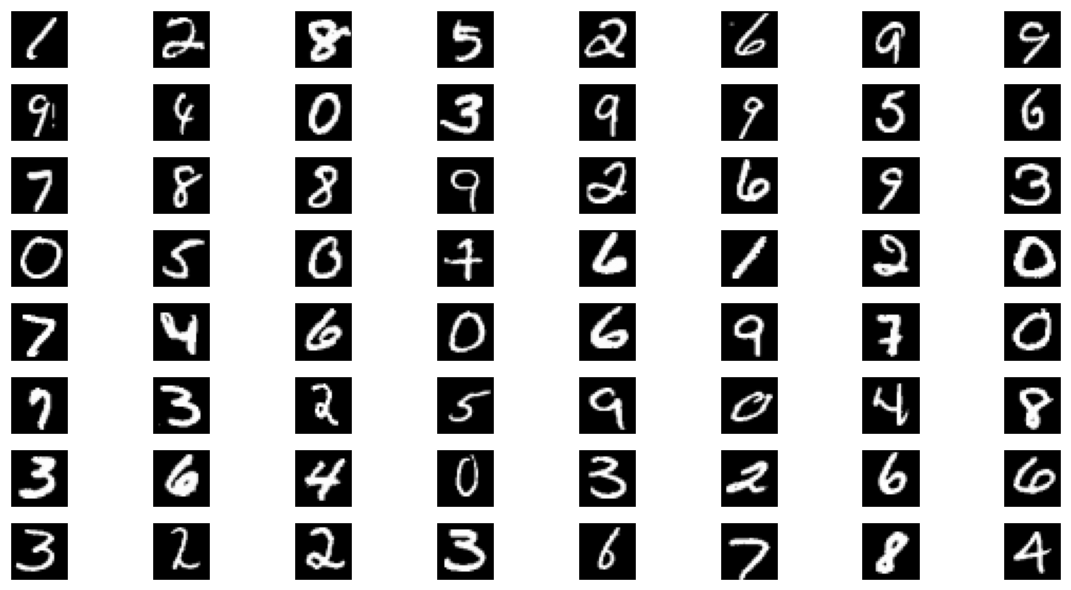

In [4]:
display_images(images=image_batch[0], n_cols=8)

In [5]:
# Instantiate Discriminator and Generator
d = Discriminator(in_features=784, out_features=1)
g = Generator(in_features=100, out_features=784)
#g = Generator(100, 32, 784)
print(d)
print()
print(g)

# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.002)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Train
n_epochs = 100
d_losses, g_losses = train_minst_gan(d, g, d_optim, g_optim, 
                                     loss_fn, dl, n_epochs, device,
                                     verbose=False)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on [cuda]...
Epoch [1/100]:
epoch_d_loss: 1.139210 	epoch_g_loss: 1.752339
Epoch [2/100]:
epoch_d_loss: 1.3

In [30]:
pytorch_total_params = sum(p.numel() for p in d.parameters())
pytorch_trainable_params = sum(p.numel() for p in d.parameters() if p.requires_grad)
print(f"Total parameters: {pytorch_total_params}")
print(f"Trainable parameters: {pytorch_trainable_params}")

Total parameters: 110849
Trainable parameters: 110849


In [31]:
pytorch_total_params = sum(p.numel() for p in g.parameters())
pytorch_trainable_params = sum(p.numel() for p in g.parameters() if p.requires_grad)
print(f"Total parameters: {pytorch_total_params}")
print(f"Trainable parameters: {pytorch_trainable_params}")

Total parameters: 114800
Trainable parameters: 114800


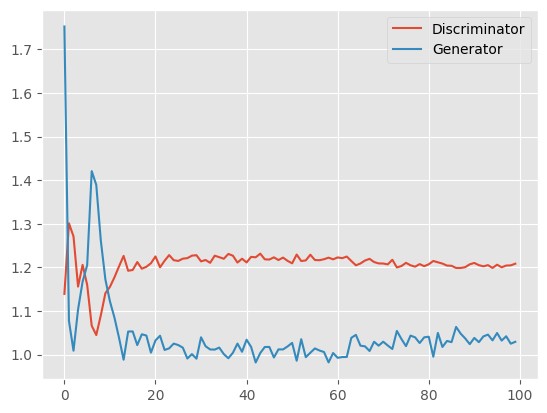

In [29]:
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

In [7]:
# Example usage:
unshuffled_dataloader = DataLoader(train_ds, batch_size=128, shuffle=False)

# Collect activations and inputs
activations, labels, inputs = collect_discriminator_activations(d, unshuffled_dataloader)



Capturing discriminator activations...
Monitoring layers: ['fc1', 'leaky_relu1', 'fc2', 'leaky_relu2', 'fc3', 'leaky_relu3', 'fc4']
Progress: 0/469 batches
Progress: 46/469 batches
Progress: 92/469 batches
Progress: 138/469 batches
Progress: 184/469 batches
Progress: 230/469 batches
Progress: 276/469 batches
Progress: 322/469 batches
Progress: 368/469 batches
Progress: 414/469 batches
Progress: 460/469 batches
Final concatenated activations shape: (60000, 449)
Labels shape: (60000,)
Inputs shape: (60000, 1, 28, 28)


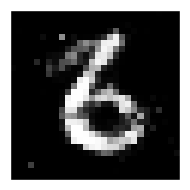

In [14]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 100))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))

Final activations shape for generated image: (1, 449)


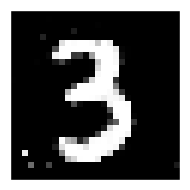

In [26]:
# Move models to the same device
g = g.to(device)
d = d.to(device)

# Generate a random latent vector and move to device
z = torch.randn(1, 100).to(device)

# Generate fake image
with torch.no_grad():
    fake_image = g(z)
    
# Collect activations for the generated image
generated_activations = collect_discriminator_activations_for_generated(g, d, z, device=device)

# # Save activations if needed
# np.save('single_generated_activations.npy', generated_activations)

# Optional: Display the generated image
fake_image_display = fake_image.cpu().view(1, 1, 28, 28).detach()
display_images(fake_image_display, n_cols=1, figsize=(2, 2))

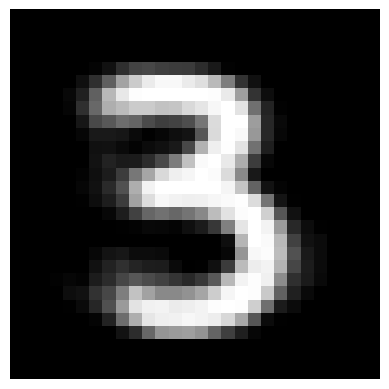

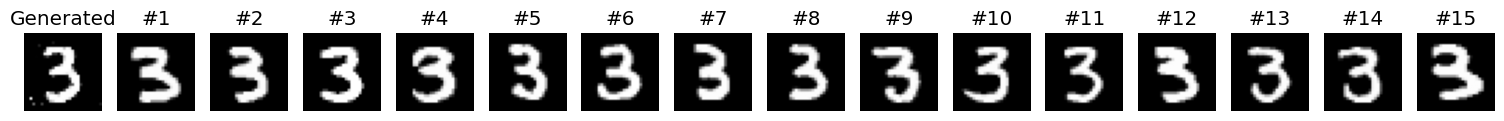

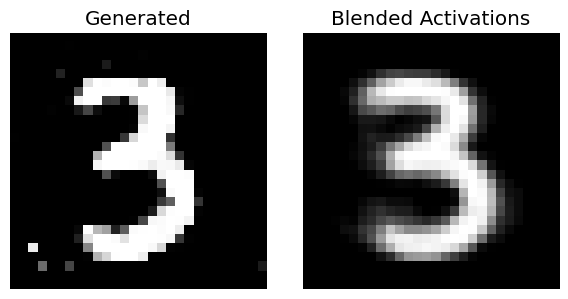

In [28]:


indices, distances = knn_search(query=generated_activations[:,:128], dataset=activations[:,:128], k=15, metric='euclidean')

#

# For activations
blended_act, act_dist = blend_samples(dataset=activations, 
                                    indices=indices, 
                                    distances=distances, 
                                    reference=generated_activations)

# For images
blended_img, img_dist = blend_samples(dataset=inputs, 
                                    indices=indices, 
                                    distances=distances, 
                                    reference=fake_image)

# Display blended image
plt.imshow(blended_img.squeeze(), cmap='gray')
plt.axis('off')
plt.show()

# Example usage:
fake_image_display = fake_image.cpu().view(1, 1, 28, 28).detach()
visualize_neighbors(fake_image_display, inputs, indices)

# Optional: Also visualize the blended result
blended_input, _ = blend_samples(dataset=inputs, indices=indices, distances=distances)
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(fake_image_display[0, 0].cpu(), cmap='gray')
plt.title('Generated')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(blended_input[0], cmap='gray')
plt.title('Blended Activations')
plt.axis('off')
plt.tight_layout()
plt.show()